<a href="https://colab.research.google.com/github/cseeg/DiSCoVeR-SuperCon-NOMAD-SMACT/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **pips and imports**

In [1]:
# imports
import pandas as pd
import numpy as np
import mat_discover
print(f"DiSCoVeR version {mat_discover.__version__}")
from mat_discover.mat_discover_ import Discover
from pymatgen.core.composition import Composition
import math
from os.path import join
from pathlib import Path
import crabnet
print(f"CrabNet version {crabnet.__version__}")
from CBFV import composition
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import smact
from smact.screening import pauling_test
import itertools
from fractions import Fraction
import functools

DiSCoVeR version 2.2.7


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CrabNet version 2.0.7


# **Read in and organize `train_df` and `val_df`**

In [2]:
# Read in data, delete unwanted columns

train_df = pd.read_csv("./2elementsfromRiccidatasets2.csv")
#train_df = df[(df[['target']] != 0).all(axis=1)]

val_df = pd.read_csv("./nomad_and_mp_2_elements_compound_validformulas.csv")

#del val_df["calc_id"]
#del val_df["count"]
#val_df.rename(columns = {'reduced_formula':'formula'}, inplace=True)
#val_df.drop(val_df.tail(1).index, inplace=True)
#val_df.dropna()

display(train_df)
display(val_df)

formula      target
0     Pu5Ru3    2.819687
1       ReO3    0.336845
2      Yb3Mg   14.406792
3      B9H11  638.974583
4     Li3Ga7    9.061345
...      ...         ...
6950    HoNi    1.943270
6951    MgGa    1.094291
6952   Bi2O3    7.885090
6953     W2C    2.647826
6954  Nb4As3    4.178441

[6955 rows x 2 columns]

formula
0      Ac2Ag3
1       Ac2Al
2      Ac2Al3
3      Ac2As3
4      Ac2Au3
...       ...
38503    RbTe
38504   Th3N4
38505  Sn7Ru3
38506  Hf3As2
38507     AlN

[38508 rows x 1 columns]

In [3]:
# Reducing the compositions in train_df using get_reduced_composition_and_factor() from pymatgen.core.composition

num_reduced_comps=[]
reduced_comps = []
for i in (train_df.loc[:,"formula"]):
  comp = Composition(i).get_reduced_formula_and_factor()
  reduced_comps.append(comp[0])
  if comp[1]>1:
    num_reduced_comps.append(comp[1])

print(f"There are {(len(num_reduced_comps))} reduced compositions")

train_df.loc[:,"formula"] = reduced_comps

display(train_df)

There are 0 reduced compositions


formula      target
0     Pu5Ru3    2.819687
1       ReO3    0.336845
2      Yb3Mg   14.406792
3      B9H11  638.974583
4     Li3Ga7    9.061345
...      ...         ...
6950    HoNi    1.943270
6951    MgGa    1.094291
6952   Bi2O3    7.885090
6953     W2C    2.647826
6954  Nb4As3    4.178441

[6955 rows x 2 columns]

In [4]:
# remove rows corresponding to formulas in val_df that overlap with train_df
cond = val_df['formula'].isin(train_df['formula'])

val_df.drop(val_df[cond].index, inplace = True)
val_df = val_df.reset_index(drop=True)
display(train_df)
display(val_df)

formula      target
0     Pu5Ru3    2.819687
1       ReO3    0.336845
2      Yb3Mg   14.406792
3      B9H11  638.974583
4     Li3Ga7    9.061345
...      ...         ...
6950    HoNi    1.943270
6951    MgGa    1.094291
6952   Bi2O3    7.885090
6953     W2C    2.647826
6954  Nb4As3    4.178441

[6955 rows x 2 columns]

formula
0      Ac2Ag3
1       Ac2Al
2      Ac2Al3
3      Ac2As3
4      Ac2Au3
...       ...
33096  Dy5Ir3
33097  Nd2Co3
33098    YFe3
33099  Re4Si7
33100  Hf3As2

[33101 rows x 1 columns]

In [5]:
# Drop NaNs in val_df and random formula named Zircaloy
val_df = val_df.dropna()
val_df = val_df[val_df["formula"].str.contains("Zircaloy") == False]
  

display(val_df)


formula
0      Ac2Ag3
1       Ac2Al
2      Ac2Al3
3      Ac2As3
4      Ac2Au3
...       ...
33096  Dy5Ir3
33097  Nd2Co3
33098    YFe3
33099  Re4Si7
33100  Hf3As2

[33101 rows x 1 columns]

#**Check validity of formulas in `train_df` and `val_df` using SMACT**

In [6]:
#define smact function

def smact_validity(comp, count,
                   use_pauling_test=True,
                   include_alloys=True):
    global compositions
    space = smact.element_dictionary(comp)
    smact_elems = [e[1] for e in space.items()]
    electronegs = [e.pauling_eneg for e in smact_elems]
    ox_combos = [e.oxidation_states for e in smact_elems]
    if len(set(comp)) == 1:
        return True
    if include_alloys:
        is_metal_list = [elem_s in smact.metals for elem_s in comp]
        if all(is_metal_list):
            return True

    threshold = np.max(count)
    compositions = []
    for ox_states in itertools.product(*ox_combos):
        stoichs = [(c,) for c in count]
        # Test for charge balance
        cn_e, cn_r = smact.neutral_ratios(
            ox_states, stoichs=stoichs, threshold=threshold)
        # Electronegativity test
        if cn_e:
            if use_pauling_test:
                try:
                    electroneg_OK = pauling_test(ox_states, electronegs)
                except TypeError:
                    # if no electronegativity data, assume it is okay
                    electroneg_OK = True
            else:
                electroneg_OK = True
            if electroneg_OK:
                for ratio in cn_r:
                    compositions.append(
                        tuple([comp, ox_states, ratio]))
    compositions = [(i[0], i[2]) for i in compositions]
    compositions = list(set(compositions))
    if len(compositions) > 0:
        return True
    else:
        return False


**First with `train_df`**

*   Formulas with floats for subscripts are computed into whole integers ex. `'Ta0.25Nb0.75'` is changed to `Ta1Nb3`



In [7]:
vals2 = []
for i in train_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  count = list(form_dict.values())

  #find least common multiple to get count as a tuple of ints
  denom_list = [(Fraction(x).limit_denominator()).denominator for x in count]
  lcm = functools.reduce(lambda a,b: a*b//math.gcd(a,b), denom_list)

  count_list= []
  for i in count:
    count_list.append(int(i*lcm))

  count = tuple(count_list)
  
  #vals2 is a list of Boolean corresponding to each formula's validity
  vals2.append(smact_validity(comp, count))

In [8]:
### 6730/12415 formulas are valid (54%)
### append Boolean vals to train_df

train_df['is_valid'] = vals2
train_df

formula      target  is_valid
0     Pu5Ru3    2.819687      True
1       ReO3    0.336845      True
2      Yb3Mg   14.406792      True
3      B9H11  638.974583     False
4     Li3Ga7    9.061345      True
...      ...         ...       ...
6950    HoNi    1.943270      True
6951    MgGa    1.094291      True
6952   Bi2O3    7.885090      True
6953     W2C    2.647826      True
6954  Nb4As3    4.178441     False

[6955 rows x 3 columns]

**Then with `val_df`**

*   Subscripts are already whole numbers
*   Takes ~15 minutes running on a GPU since there are a lot of formulas

In [9]:
vals = []
for i in val_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  lyst = list(form_dict.values())
  lyst = [int(x) for x in lyst]
  count = tuple(lyst)

  vals.append(smact_validity(comp, count))



In [10]:
### 544383/694398 formulas are valid (78.3964%)
### append Boolean vals to val_df

val_df['is_valid'] = vals
val_df

formula  is_valid
0      Ac2Ag3      True
1       Ac2Al      True
2      Ac2Al3      True
3      Ac2As3     False
4      Ac2Au3      True
...       ...       ...
33096  Dy5Ir3      True
33097  Nd2Co3      True
33098    YFe3      True
33099  Re4Si7     False
33100  Hf3As2      True

[33101 rows x 2 columns]

#**Train dummy model and DiSCoVeR model**

**First set up and test on a dummy regressor (using mat2vec as the CBFV) and calculate error metrics**


In [11]:
X,y,formulae,skipped=composition.generate_features(train_df,elem_prop='mat2vec')

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
y_pred = dummy_regr.predict(X)

print(f"MAE on Dummy Regressor: {mean_absolute_error(y, y_pred)}")
print(f"MSE on Dummy Regressor: {mean_squared_error(y, y_pred)}")
print(f"R squared on Dummy Regressor: {r2_score(y, y_pred)}")



Processing Input Data: 100%|██████████| 6955/6955 [00:00<00:00, 13082.39it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 6955/6955 [00:00<00:00, 7105.34it/s]


	Creating Pandas Objects...
MAE on Dummy Regressor: 275.345819161752
MSE on Dummy Regressor: 94224.01955493374
R squared on Dummy Regressor: 0.0


**Next set up DiSCoVeR model**

In [12]:
# initialize DiSCoVeR model

#disc = Discover(target_unit="µV/K")
disc = Discover(hdbscan_kwargs=dict(min_samples=1, min_cluster_size=256), use_plotly_offline=False, target_unit="µV/K", dist_device="cpu")

In [13]:
#shuffle data

train_df = train_df.sample(frac=1)

val_df = val_df.sample(frac=1)

display(train_df)
display(val_df)

formula      target  is_valid
5488    Na2O  884.367967      True
2855   Mg3Au    0.899968      True
2133    Ag3P    2.823882      True
37      KSr3    3.774166      True
2063    NdF3  735.405180      True
...      ...         ...       ...
3772      BN  709.087843      True
5191   Al2O3   59.129561      True
5226   TiSi2    6.212832      True
5390   In3Cu    0.293484      True
860    SmTm3    7.601741      True

[6955 rows x 3 columns]

formula  is_valid
17969    La5Co3      True
27745    Sn6Au7      True
1697      AlIr3      True
15374  In17Ru12      True
25186    Pr7O12     False
...         ...       ...
2244       Au4C      True
3203      Ba4Bi      True
28885     Tb3Fe      True
5204       BiP4     False
30825     Zn2Pb      True

[33101 rows x 2 columns]

**Fit training data on DiSCoVeR**

In [14]:
disc.fit(train_df)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 5564/5564 [00:00<00:00, 171099.44formulae/s]


loading data with up to 2 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 1391/1391 [00:00<00:00, 198782.86formulae/s]


loading data with up to 2 elements in the formula
stepping every 220 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 231 val mae: 227
Epoch: 19/300 --- train mae: 58.7 val mae: 76.3
Epoch: 39/300 --- train mae: 42.6 val mae: 71.3
Epoch: 59/300 --- train mae: 36.7 val mae: 70.4
Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 33 val mae: 72.1
Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 30.4 val mae: 73.1
Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 27.6 val mae: 72.9
Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth
[train-CrabNet]
Elapsed: 37973.09784



**Predict val_df in chunks**

In [15]:
#Predict through val_df in chunks (chunks are split to match 70/30 Training/Validation data)
#There are 70 chunks each with ~10,000 compositions

dens_score = []
peak_score = []

val_dfs = np.array_split(val_df, 10)
# print((val_dfs[0]))

jd = 0
for i, val_df in enumerate(val_dfs):
    jd = jd + 1
    disc.predict(val_df, umap_random_state=42)
    dens_score.append(disc.dens_score_df.sample(frac=1))
    peak_score.append(disc.peak_score_df.sample(frac=1))
    print(f"\nDone with iteration {jd}\n")

Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 210462.64formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3311/3311 [00:00<00:00, 188180.45formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  193.84675225632427
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c214f38d00 at 0x000001C21509B820>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21820f430 at 0x000001C214BB1C10>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c214ec28b0 at 0x000001C272CC6EE0>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 127.59204



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 54.0945



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.92654

[DensMAP]
Elapsed: 79.02205

[HDBSCAN*]
Elapsed: 0.1424

[pdf-summation]
Elapsed: 12.73465

[gridded-pdf-summation]
Elapsed: 12.95713

[train-val-pdf-summation]
Elapsed: 2.72644

[nearest-neighbor-properties]
Elapsed: 3.13958


Done with iteration 1



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 239492.50formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 194720.00formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  199.4600857827126
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c272e801f0 at 0x000001C21A536CA0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2588fca60 at 0x000001C272B9C1F0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2193b3820 at 0x000001C2735CD820>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 130.09288



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 35.83123



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.41053

[DensMAP]
Elapsed: 60.29435

[HDBSCAN*]
Elapsed: 0.1274

[pdf-summation]
Elapsed: 11.56835

[gridded-pdf-summation]
Elapsed: 11.67486

[train-val-pdf-summation]
Elapsed: 2.23708

[nearest-neighbor-properties]
Elapsed: 2.47713


Done with iteration 2



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 204407.37formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 187820.75formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  191.30853669701682
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21835a970 at 0x000001C2195E0D30>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c24e354a90 at 0x000001C24E337C10>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21930bc10 at 0x000001C21A5365E0>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 123.71629



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 35.88776



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.57102

[DensMAP]
Elapsed: 60.50821

[HDBSCAN*]
Elapsed: 0.11855

[pdf-summation]
Elapsed: 11.30898

[gridded-pdf-summation]
Elapsed: 11.42357

[train-val-pdf-summation]
Elapsed: 2.36517

[nearest-neighbor-properties]
Elapsed: 2.45226


Done with iteration 3



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 224367.65formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 189007.21formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  197.2473671397147
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2588e5cd0 at 0x000001C214C67550>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21ab5ca00 at 0x000001C220E97DC0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c272b9b4c0 at 0x000001C214B6A3A0>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 125.6902



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 35.68132



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.70987

[DensMAP]
Elapsed: 60.43874

[HDBSCAN*]
Elapsed: 0.12251

[pdf-summation]
Elapsed: 11.31728

[gridded-pdf-summation]
Elapsed: 11.42882

[train-val-pdf-summation]
Elapsed: 2.32827

[nearest-neighbor-properties]
Elapsed: 2.45527


Done with iteration 4



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 201484.88formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 194313.91formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  199.66633500685947
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2150730d0 at 0x000001C2195E0160>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c217930d60 at 0x000001C21A81CC10>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21a5a2f40 at 0x000001C2010870D0>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 124.61782



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 36.04133



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.31034

[DensMAP]
Elapsed: 60.40226

[HDBSCAN*]
Elapsed: 0.12852

[pdf-summation]
Elapsed: 11.32323

[gridded-pdf-summation]
Elapsed: 11.43978

[train-val-pdf-summation]
Elapsed: 2.27591

[nearest-neighbor-properties]
Elapsed: 2.44041


Done with iteration 5



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 231859.35formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 174185.99formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  198.78762033470124
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c218e050a0 at 0x000001C219754C10>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2190aa820 at 0x000001C2735C33A0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21a682670 at 0x000001C2178E95E0>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 130.73828



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 36.53443



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.46689

[DensMAP]
Elapsed: 61.04996

[HDBSCAN*]
Elapsed: 0.11749

[pdf-summation]
Elapsed: 11.31238

[gridded-pdf-summation]
Elapsed: 11.41489

[train-val-pdf-summation]
Elapsed: 2.09522

[nearest-neighbor-properties]
Elapsed: 2.51911


Done with iteration 6



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 201664.56formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 168699.75formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  185.60638594588184
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2187600a0 at 0x000001C217B30790>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c218783130 at 0x000001C214DC53A0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2190cd370 at 0x000001C202E2C310>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 124.78123



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 36.44213



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.79127

[DensMAP]
Elapsed: 61.2815

[HDBSCAN*]
Elapsed: 0.12352

[pdf-summation]
Elapsed: 11.24099

[gridded-pdf-summation]
Elapsed: 11.35548

[train-val-pdf-summation]
Elapsed: 2.34362

[nearest-neighbor-properties]
Elapsed: 2.53351


Done with iteration 7



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 217340.07formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 194197.04formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  207.33028820475155
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c218d5dfa0 at 0x000001C214EFD430>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21929f310 at 0x000001C220E97F70>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c2734ed250 at 0x000001C214B6AF70>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 131.07031



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 36.39287



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.62143

[DensMAP]
Elapsed: 61.06131

[HDBSCAN*]
Elapsed: 0.11903

[pdf-summation]
Elapsed: 11.16082

[gridded-pdf-summation]
Elapsed: 11.27135

[train-val-pdf-summation]
Elapsed: 2.27226

[nearest-neighbor-properties]
Elapsed: 2.39885


Done with iteration 8



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 180727.36formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 183902.22formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  188.55407962597198
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c214fbbb50 at 0x000001C2037E3790>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c214fd4f70 at 0x000001C2735C3310>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c219674070 at 0x000001C214DA1700>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 134.45062



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 37.77107



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 25.0108

[DensMAP]
Elapsed: 62.83087

[HDBSCAN*]
Elapsed: 0.12551

[pdf-summation]
Elapsed: 12.43845

[gridded-pdf-summation]
Elapsed: 12.57596

[train-val-pdf-summation]
Elapsed: 2.38877

[nearest-neighbor-properties]
Elapsed: 2.67656


Done with iteration 9



Generating EDM: 100%|██████████| 6955/6955 [00:00<00:00, 239811.45formulae/s]


loading data with up to 2 elements in the formula


Generating EDM: 100%|██████████| 3310/3310 [00:00<00:00, 200446.81formulae/s]


loading data with up to 2 elements in the formula
val RMSE:  182.53864127126425
Fitting mod_petti kernel matrix
Constructing distances


c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c272b829d0 at 0x000001C216FDA0D0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c21a5badf0 at 0x000001C2178E95E0>. Debug line information may be inaccurate.

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\numba\core\lowering.py:107: NumbaDebugInfoWarning:

Could not find source for function: <function __numba_parfor_gufunc_0x1c219043fa0 at 0x000001C219752E50>. Debug line information may be inaccurate.



[fit-wasserstein]
Elapsed: 127.98163



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 37.20726



c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\umap\umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 24.89189

[DensMAP]
Elapsed: 62.15115

[HDBSCAN*]
Elapsed: 0.13663

[pdf-summation]
Elapsed: 11.39276

[gridded-pdf-summation]
Elapsed: 11.51028

[train-val-pdf-summation]
Elapsed: 2.37204

[nearest-neighbor-properties]
Elapsed: 2.44396


Done with iteration 10



In [20]:
# Organize list of DataFrames and sort by score

dens_score_df = pd.DataFrame()
peak_score_df = pd.DataFrame()

for i in dens_score:
  dens_score_df = dens_score_df.append(i, ignore_index=True)

dens_score_df.sort_values('score',inplace=True,ascending=False)

for j in peak_score:
  peak_score_df = peak_score_df.append(j, ignore_index=True)

peak_score_df.sort_values('score',inplace=True,ascending=False)

display(dens_score_df.head(25))
print("")
display(peak_score_df.head(25))

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32500\4195086505.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_32500\4195086505.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



formula  prediction    density       score  index
27372      PF6  867.988953  14.750200  111.363711  24714
26720      KF5  851.863586   7.487938  109.918872  17177
206       CrF6  863.368958   4.315226  107.906120   8891
18210     TcF6  868.070740   5.054356  105.463591  32935
7565      SeF6  862.631470  16.711125  104.970869  27101
27853     SbF5  816.926270  15.673422  104.647107  26387
239       SbF6  845.104614  17.678294  104.310841  26388
12789     LiF3  851.162659   8.569879  103.831243  19327
26648     C3F8  805.595398  16.231040  103.125105   5370
26534     TcF4  791.687683   6.166315  102.219262  31607
26513      HO4  796.919800  13.888725  102.207680  13311
9108    Sb2F13  840.146545  17.194352  102.150735  32626
413        HF3  828.020630  25.270325  101.426949  13299
19500      CF3  840.040283  14.574568  101.145504   5483
29694     BaF3  776.981140   8.348605  100.113255  31979
11746      BF4  830.815430  22.055127  100.015706   2700
26512     PCl7  785.169434  21.482107  100.001320  24710
18838     ReF3  823.576721  11.058921   99.467393  25807
20783      NF3  808.916138  20.401296   99.034893  22469
10952  Li31F33  808.064087   4.787926   98.901204  18691
21785     RuF6  795.651611   4.057928   98.835442  31856
263       V2F9  791.936035   5.887127   98.793048  30329
29548      OF2  791.885864  44.742647   98.791568  32098
474    Li33F32  792.691406   7.408775   98.739256  18694
28697  Bi5Br24  774.012146  21.153559   98.581201   5036

formula  prediction    density       score  index
27015     PmF2  757.187927   8.114142  227.487566  25121
12044     LiF3  851.162659   8.569879  222.488526  19327
6187       KF3  853.455200   7.758723  219.791215  32465
21044      CsK  689.638123  10.384192  214.803315   9218
10532    PmBr2  707.428162   5.167479  213.436886  25113
15843      KF3  853.455200  10.725698  213.033057  17176
20132    FeCl6  787.175781   7.340558  212.943048  11480
17032     TcF6  868.070740   5.054356  210.391538  32935
29270     PaO2  719.689392   9.167962  208.866664  31923
11516      KNa  687.479248   7.007748  207.949715  17272
26601    PmCl2  702.308044   8.130435  207.502166  25117
21263    FeCl7  785.423340   7.321932  206.608340  11481
29210      KMg  662.495483  10.223430  206.585237  17248
2064      CrF6  863.368958   4.315226  202.481575   8891
15618     CrF6  863.368958   4.237433  201.980835  31685
4727   Au5Cl24  783.230957   7.859601  201.711649   2266
5939     AuCl5  781.164551   7.821692  201.631851   2304
29691     BaF3  776.981140   8.348605  201.145280  31979
28991      BC2  690.693604  23.711817  200.695065   2690
18566     ReF3  823.576721  11.058921  200.106570  25807
21458     RuF6  795.651611   4.057928  199.978749  31856
149       AuF3  780.696289  12.352786  199.934139   2308
512      Mg2O7  732.955688  14.996407  199.881424  19994
22143    AgBr2  743.854919  12.316122  199.662466    703
32516     MgF3  810.712402  11.432594  197.956561  20746

**Append the Boolean values to each dataframe and then resort by score**

In [21]:
dens_score_df = dens_score_df.sort_values(by='index')
dens_score_df['is_valid'] = val_df['is_valid']
dens_score_df = dens_score_df.sort_values(by='score', ascending=False)


peak_score_df = peak_score_df.sort_values(by='index')
peak_score_df['is_valid'] = val_df['is_valid']
peak_score_df = peak_score_df.sort_values(by='score', ascending=False)

In [22]:
dsdf = dens_score_df.drop(['index'], axis=1)
dsdf

formula  prediction      density       score is_valid
27372     PF6  867.988953    14.750200  111.363711      NaN
26720     KF5  851.863586     7.487938  109.918872      NaN
206      CrF6  863.368958     4.315226  107.906120      NaN
18210    TcF6  868.070740     5.054356  105.463591      NaN
7565     SeF6  862.631470    16.711125  104.970869      NaN
...       ...         ...          ...         ...      ...
9274     InO2  146.915024   564.053515  -33.125548      NaN
29858    FeI2  309.231659   809.432837  -39.604848      NaN
18570    AlI2  690.352051  1463.637550  -53.655725      NaN
15584    TlO2   12.173767   659.007292  -55.378994      NaN
3026   Pb7O16   10.983337  3008.935806 -292.301852      NaN

[33101 rows x 5 columns]

In [23]:
psdf = peak_score_df.drop(['index'], axis=1)


**Import/Export files for future use**

In [24]:
disc.save('discovery_2_elements_model_mp.pkl')

In [25]:
#export dens_score and peak_score as csv files

dsdf.to_csv(r"./dens_score.csv", index = False)

psdf.to_csv(r"./peak_score.csv", index = False)

In [ ]:
#import files if needed

dens_score_df = pd.read_csv("./dens_score.csv")
peak_score_df = pd.read_csv("./peak_score.csv")

#**Visualizing data**

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




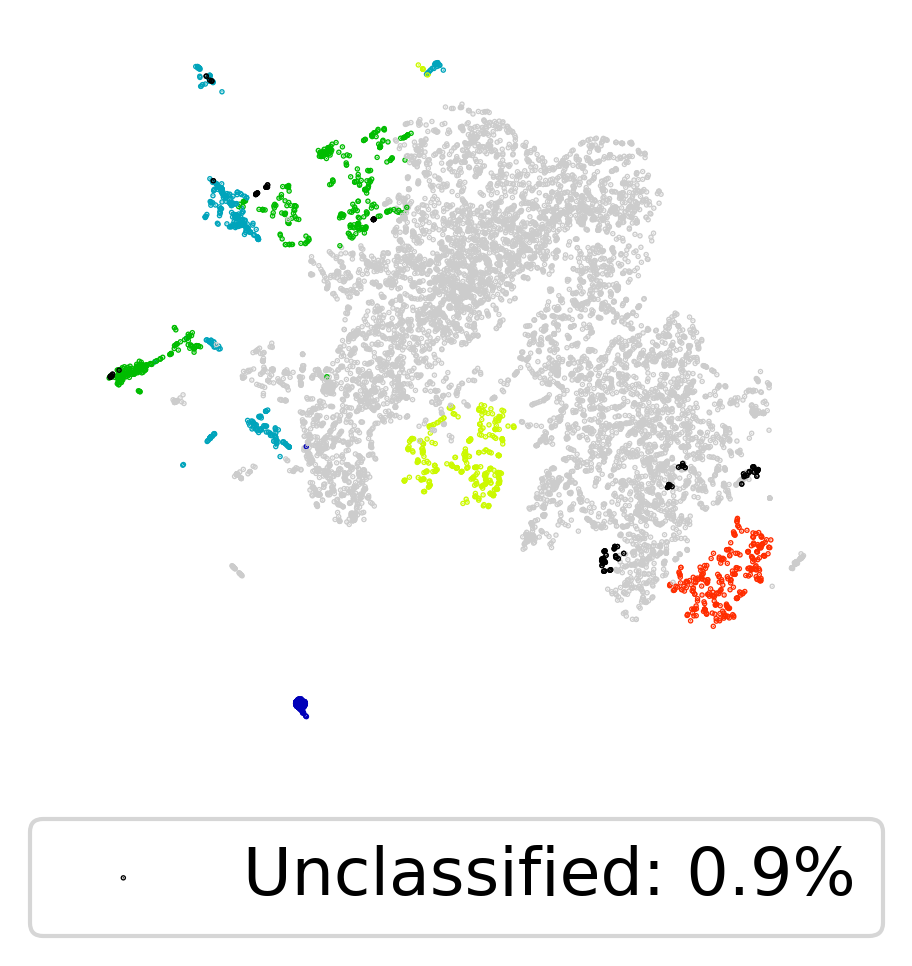

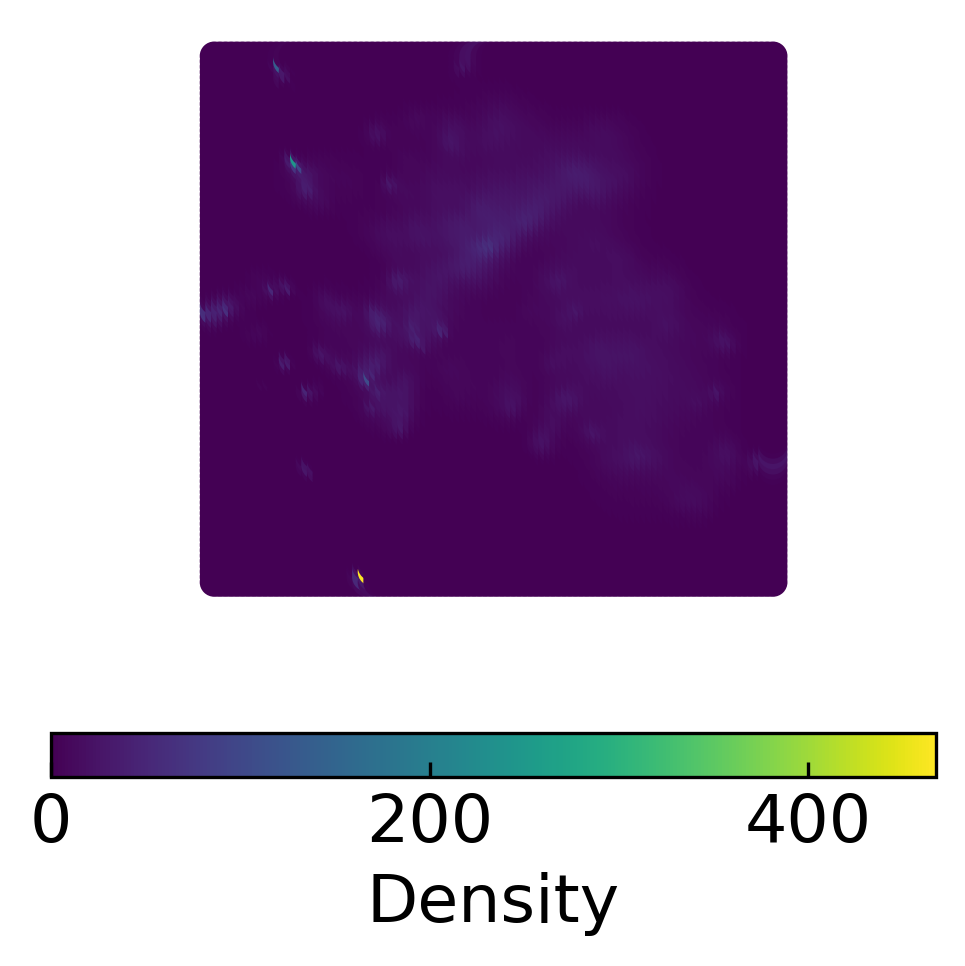

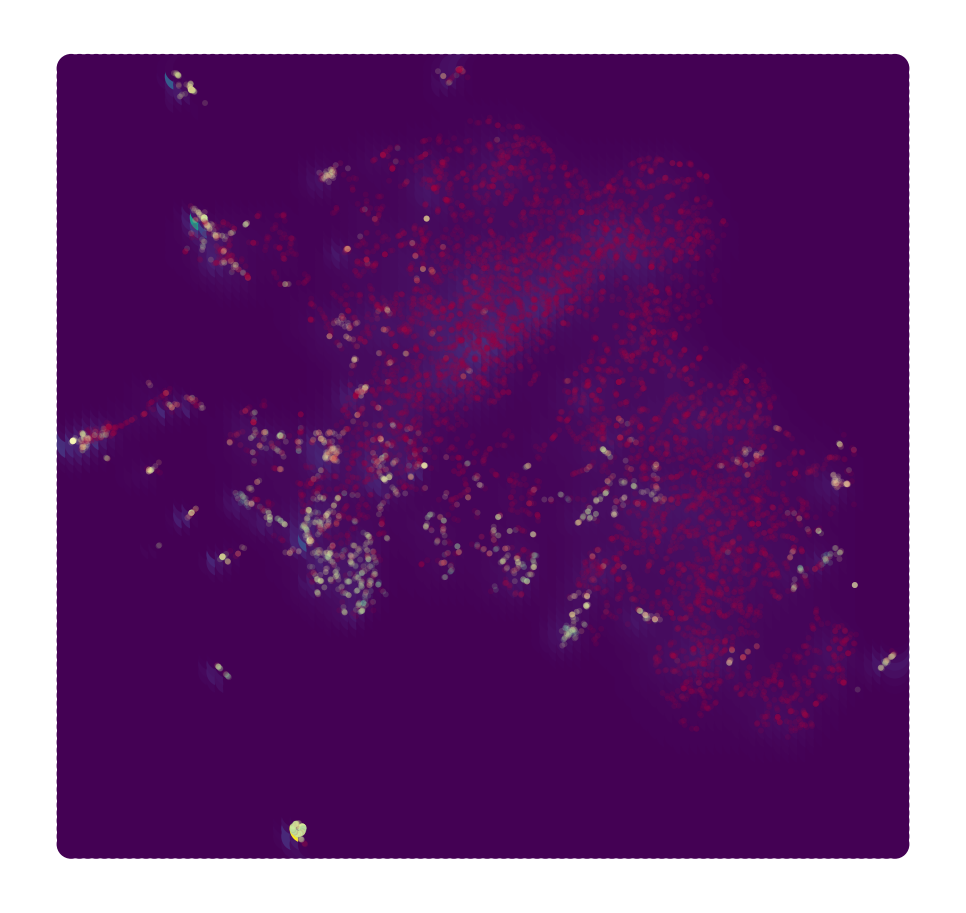

c:\Users\ThinkPad\anaconda3\envs\mat_discover2\lib\site-packages\mat_discover\mat_discover_.py:1359: UserWarning:

Skipping group cross-validation plot



In [26]:
disc.plot()

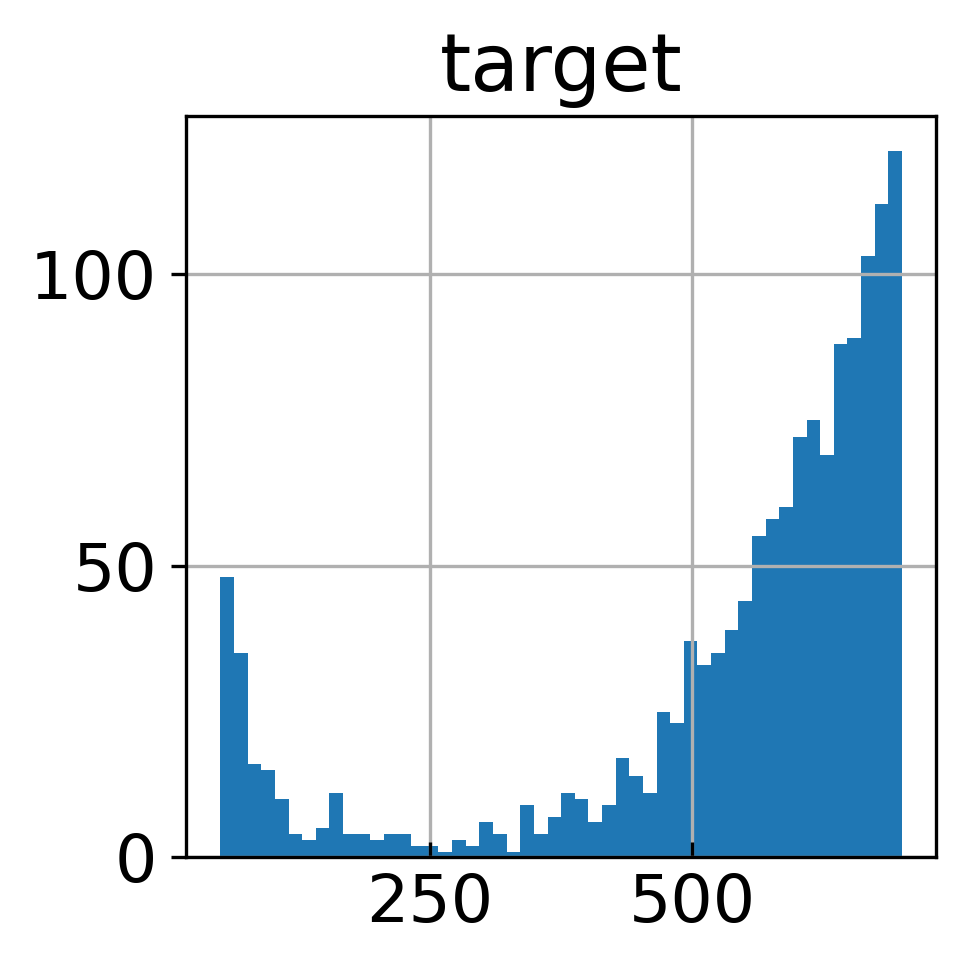

In [27]:
#Histogram of train_df with critical temperatures above 77.36 which is the range for high-temperature superconductors

hist = train_df.hist(column='target', bins=50, range=[50,700], align='mid')

There are 4779 predicted thermoelectric materials with Seebeck Co-efficient above 50 µV/K


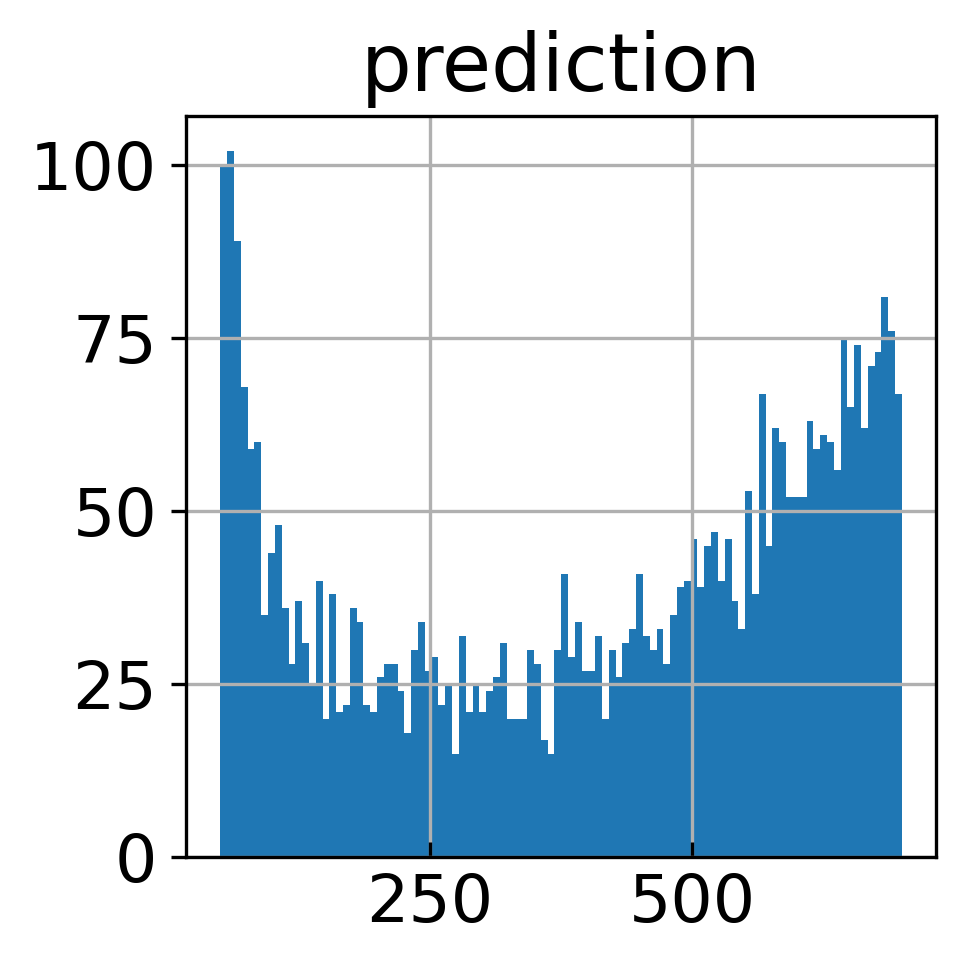

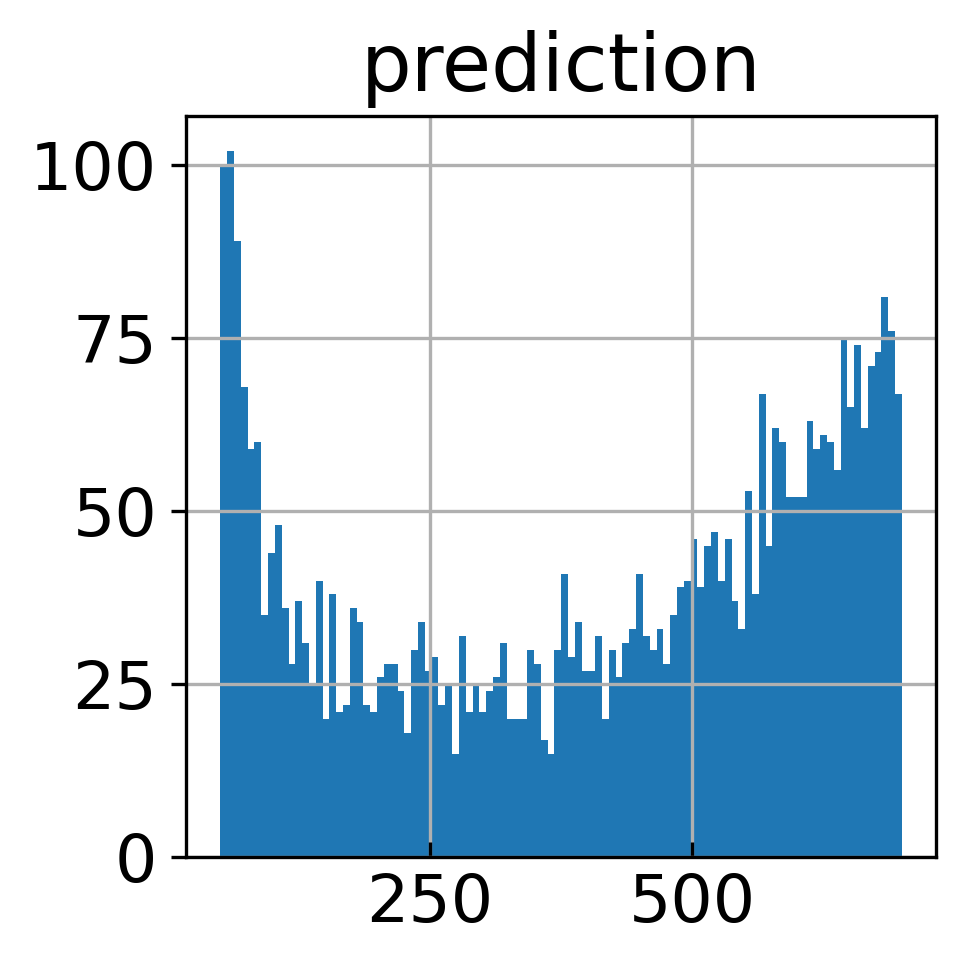

In [28]:
#histograms for predictions

dens_hist = dens_score_df.hist(column='prediction', bins=100 ,align='mid', range= [50,700])

peak_hist = peak_score_df.hist(column='prediction', bins=100 ,align='mid', range= [50,700])

print(f"There are {(peak_score_df['prediction'] >= 50).sum()} predicted thermoelectric materials with Seebeck Co-efficient above 50 µV/K")